In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In [2]:
import numpy as np
import pandas as pd
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
#import emachine as EM
from direct_info import direct_info

from data_processing import data_processing
import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1)

## Read in Protein Structure
1. We will start by reading in a set of Protein structures with the given Protein ID "pfam_id"
    * [More Info on working with PDB structures in DataFrames](http://rasbt.github.io/biopandas/tutorials/Working_with_PDB_Structures_in_DataFrames/)

In [3]:
# Read in Protein structure
data_path = '../protein/Pfam-A.full'
pfam_id = 'PF00186'
pdb = np.load('%s/%s/pdb_refs.npy'%(data_path,pfam_id))

In [4]:
# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])

In [5]:
# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

number of pdb structures: 372


In [6]:
# Print PDB array 
print(pdb)
print(pdb[0])

[['PF00186' '69' 'Q5KZ26_GEOKA' ... 'B' '1' '160']
 ['PF00186' '69' 'Q5KZ26_GEOKA' ... 'A' '1' '160']
 ['PF00186' '83' 'Q81R22_BACAN' ... 'B' '2' '160']
 ...
 ['PF00186' '6952' 'DYR_MYCTU' ... 'A' '1' '158']
 ['PF00186' '7457' 'Q834R2_ENTFA' ... 'A' '1' '161']
 ['PF00186' '7457' 'Q834R2_ENTFA' ... 'A' '1' '161']]
['PF00186' '69' 'Q5KZ26_GEOKA' '1' '160' '1ZDR' 'B' '1' '160']


1. Using the array of PDB structures above we will create a pandas database for easy data manipulation

In [7]:
# Create pandas dataframe for protein structure
df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_start',\
                                 'pdb_id','chain','pdb_start','pdb_end'])
df.head()

,PF,seq,id,uniprot_start,uniprot_start,pdb_id,chain,pdb_start,pdb_end
0,PF00186,69,Q5KZ26_GEOKA,1,160,1ZDR,B,1,160
1,PF00186,69,Q5KZ26_GEOKA,1,160,1ZDR,A,1,160
2,PF00186,83,Q81R22_BACAN,2,160,3JWK,B,2,160
3,PF00186,83,Q81R22_BACAN,2,160,3S9U,B,2,160
4,PF00186,83,Q81R22_BACAN,2,160,3FL9,H,2,160


### PDB Website Search Engine
   * We can visualize the complex structure of the proteins
   * The data-base below gives further information on the proteins above (input pdb_id)

In [8]:
hide_toggle(for_next=True) # Hide html code for PDB website
hide_toggle()

In [9]:
%%html
<iframe src="https://www.rcsb.org" width="600" height="500"></iframe>

### Define contact map
2. Import contact map functions from newly defined tools python module

In [10]:
import ecc_tools as tools

In [11]:
ipdb = 0
print('seq:',int(pdb[ipdb,1]))

# data processing
s0,cols_removed = data_processing(data_path,pfam_id,ipdb,\
                gap_seqs=0.2,gap_cols=0.2,prob_low=0.004,conserved_cols=0.9)

ct = tools.contact_map(pdb,ipdb,cols_removed)

seq: 69
Structure exists: '/home/eclay/DCA_ER/zd/pdb1zdr.ent' 


3. Plot the contact Map of the imported Protein structure

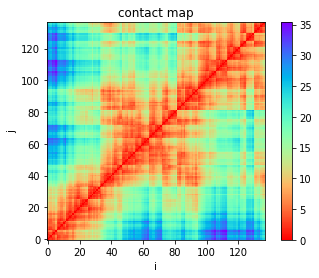

In [12]:
plt.title('contact map')
plt.imshow(ct,cmap='rainbow_r',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()
hide_toggle()

## Now we want to use Expectation Reflection to infer the "calculate the weights " 
  * Infer interactions between residues (R-part of ammino acid) in proteins from Multiple Sequence Alignment (MSA) data
  * More understanding required on meaning/interpretation of weights
  
1. We can start by defining some important values of our protein structures
    * It is important to define 'i1i2' vector to keep track of OneHot index positions (i) coresonding to the beginning and end of a given amino acid position (this acts as a key between the OneHot matrix (s) and the original sequence matrix (s0)

In [13]:
# number of positions
n_var = s0.shape[1]
print("Number of residue positions:",n_var)

# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
#mx = np.array([m for i in range(n_var)])
print("Number of different amino acids at each position",mx)

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 
print("(Sanity Check) Column indices of first and (",i1i2[0],") and last (",i1i2[-1],") positions")
print("(Sanity Check) Column indices of second and (",i1i2[1],") and second to last (",i1i2[-2],") positions")


# number of variables
mx_sum = mx.sum()
print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_var

Number of residue positions: 137
Number of different amino acids at each position [ 6 16 12  7  8 16  8 17 12 14  9 19 11 10 13  5  5 14  9  6 11  2  9 12
 11  9 10 16 17 11 12 13  5  4  9  7 11  6  5 10 12 10  9  9 17  8  8  2
  5  2 11 11 18 18 20 20 20 14 13 15 16 15 14 14  7 12 15 12  8 15 15 21
 19 16 16 20 15 17 13 11  8 10 12 13  4  3 13 15 12 11 13 19  9 11 17  7
 14  8 16  3 16 19 15 14 15  7  7 15  7 17 10 16 20 17 18  5 17 16 17 20
 19 18 21 21 19 15 17 13 16 13 14 10 14  9 18 14  5]
(Sanity Check) Column indices of first and ( [0 6] ) and last ( [1697 1702] ) positions
(Sanity Check) Column indices of second and ( [ 6 22] ) and second to last ( [1683 1697] ) positions
Total number of variables 1702


2.  The above indices help to divide all the possible amino acids at different positions to binary choices which will be implemented wit 1 of K notation (OneHot Encoder)

In [14]:
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
# s is OneHot encoder format, s0 is original sequnce matrix
s = onehot_encoder.fit_transform(s0)
print("Amino Acid sequence Matrix\n",s0)
print("OneHot sequence Matrix\n",s)
print("An individual element of the OneHot sequence Matrix (size:",
      s.shape,") --> ",s[0], " has length ",s[0].shape)

Amino Acid sequence Matrix
 [[ 7 15  4 ...  3 17 18]
 [ 9  0  9 ... 17 17 19]
 [20 20 17 ... 20 20 20]
 ...
 [17 15  9 ... 11 17 19]
 [17 15  0 ...  8 17 19]
 [ 4 15  7 ...  7  7 19]]
OneHot sequence Matrix
 [[0. 1. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 1. 0.]]
An individual element of the OneHot sequence Matrix (size: (6734, 1702) ) -->  [0. 1. 0. ... 1. 0. 0.]  has length  (1702,)


#### OneHot Format example
* Given 3 sequence poitions each with 3 different amino acids:
    * Notation: The 3<sup>rd</sup> amino acid type at the 2<sup>nd</sup> sequence position is denoted as R23<br/>
* OneHot converts the sequence [R11 R22 R33] &rightarrow; [1 0 0 0 1 0 0 0 1]  
  
  
3. We next want to define our local field parameters

In [15]:
# Define wight matrix with variable for each possible amino acid at each sequence position
w = np.zeros((mx.sum(),mx.sum())) 
h0 = np.zeros(mx.sum())

### Apply Expectation Reflection
4. We can now apply expectation reflection to infer the connection between postion residues

In [16]:
import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import expectation_reflection as ER
from direct_info import direct_info
from joblib import Parallel, delayed

In [17]:
# Expectation Reflection
#=========================================================================================
def predict_w(s,i0,i1i2,niter_max,l2):
    #print('i0:',i0)
    
    # Get bounds of OneHot Matrix for amino acid sequence postion i0
    i1,i2 = i1i2[i0,0],i1i2[i0,1]
    

    # Separate into x - all other positions and, y - position i0
    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    # Find coupling between x and y using Expectation Reflection (ER)
    h01,w1 = ER.fit(x,y,ct_w(s,i0,i1i2,niter_max,l2):
    #print('i0:',i0)
    
    # Get bounds of OneHot Matrix for amino acid sequence postion i0
    i1,i2 = i1i2[i0,0],i1i2[i0,1]
    

    # Separate into x - all other positions and, y - position i0
    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    # Find coupling between x and y using Expectation Reflection (ER)
    h01,w1 = ER.fit(x,y,niter_max,l2)

    return h01,w1

#-------------------------------
# parallel
start_time = timeit.default_timer()
#res = Parallel(n_jobs = 4)(delayed(predict_w)\
res = Parallel(n_jobs = 8)(delayed(predict_w)\
#res = Parallel(n_jobs = 32)(delayed(predict_w)\
        (s,i0,i1i2,niter_max=10,l2=100.0)\
        for i0 in range(n_var))

run_time = timeit.default_timer() - start_time
print('run time:',run_time)
## This above line seems wrong, seems like the following for loop should be moved up?? not sure if this is some 
## python implementation or just wrong
#----------------niter_max,l2)

    return h01,w1

#-------------------------------
# parallel
start_time = timeit.default_timer()
#res = Parallel(n_jobs = 4)(delayed(predict_w)\
res = Parallel(n_jobs = 8)(delayed(predict_w)\
#res = Parallel(n_jobs = 32)(delayed(predict_w)\
        (s,i0,i1i2,niter_max=10,l2=100.0)\
        for i0 in range(n_var))

run_time = timeit.default_timer() - start_time
print('run time:',run_time)
## This above line seems wrong, seems like the following for loop should be moved up?? not sure if this is some 
## python implementation or just wrong
#-------------------------------
for i0 in range(n_var):
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    h01 = res[i0][0]
    w1 = res[i0][1]

    h0[i1:i2] = h01
    w[:i1,i1:i2] = w1[:i1,:]
    w[i2:,i1:i2] = w1[i1:,:]

# make w symmetric
w = (w + w.T)/2.



run time: 415.6223458329987


5. Now we want to plot a heat map of our sequence weights

In [18]:
# Verify that w is symmetric (sanity test)
print("Dimensions of w: ",w.shape)

Dimensions of w:  (1702, 1702)


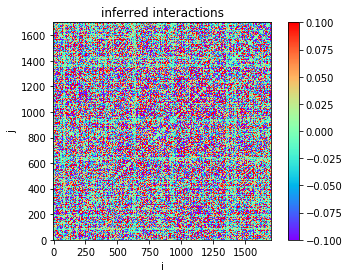

In [19]:
plt.title('inferred interactions')
plt.imshow(w,cmap='rainbow',origin='lower')
plt.clim(-0.1,0.1)
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar(fraction=0.045, pad=0.05)
hide_toggle()

6. Plot relationship between sequence positions via Direct information

In [20]:
di = direct_info(s0,w)

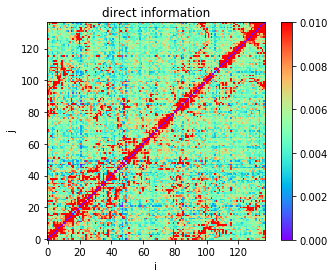

In [21]:
plt.title('direct information')
plt.imshow(di,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)

auc max: 2.0 0.8595775385850963


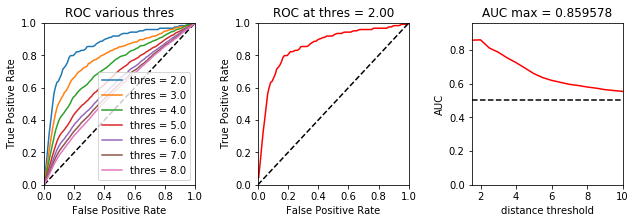

In [22]:
# find optimal threshold of distance
ct_thres = np.linspace(1.5,10.,18,endpoint=True)
n = ct_thres.shape[0]

auc = np.zeros(n)
for i in range(n):
    p,tp,fp = tools.roc_curve(ct,di,ct_thres[i])
    auc[i] = tp.sum()/tp.shape[0]

#np.savetxt('auc.dat',(ct_thres,auc),fmt='%f')    

#>
# plot at optimal threshold:
i0 = np.argmax(auc)
print('auc max:',ct_thres[i0],auc[i0])
p0,tp0,fp0 = tools.roc_curve(ct,di,ct_thres[i0])

iplot = [1,3,5,7,9,11,13]
plt.figure(figsize=(9.0,3.2))

plt.subplot2grid((1,3),(0,0))
plt.title('ROC various thres')
plt.plot([0,1],[0,1],'k--')
for i in iplot:
    p,tp,fp = tools.roc_curve(ct,di,ct_thres[i])
    plt.plot(fp,tp,label='thres = %s'%ct_thres[i])

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot2grid((1,3),(0,1))
plt.title('ROC at thres = %3.2f'%(ct_thres[i0]))
plt.plot(fp0,tp0,'r-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.subplot2grid((1,3),(0,2))
plt.title('AUC max = %f' %(auc[i0]))
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc,'r-')
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.ylim([0,auc.max()+0.1])
plt.xlabel('distance threshold')
plt.ylabel('AUC')

plt.tight_layout(h_pad=1, w_pad=1.5)
